In [1]:
import netCDF4
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from mpl_toolkits.axes_grid1 import axes_grid
from utils.config import LINEAR_ENCODER
from utils import CROP_ENCODING

In [2]:
#patch = netCDF4.Dataset(Path('data/2020_31TCG_patch_14_14.nc'), 'r')
patch = netCDF4.Dataset(Path('dataset/netcdf/2019_31TBF_patch_17_13.nc'), 'r')
patch

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: S4A Patch Dataset
    authors: Papoutsis I., Sykas D., Zografakis D., Sdraka M.
    patch_full_name: 2019_31TBF_patch_17_13
    patch_year: 2019
    patch_name: patch_17_13
    patch_country_code: ES
    patch_tile: 31TBF
    creation_date: 27 Apr 2021
    references: Documentation available at .
    institution: National Observatory of Athens.
    version: 21.03
    _format: NETCDF4
    _nco_version: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    _xarray_version: 0.17.0
    dimensions(sizes): 
    variables(dimensions): 
    groups: B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A, labels, parcels

In [3]:
bands = {
    'B02':  {
        'title': 'B02 - Blue',
        'band': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02,
        'uint8': np.array((xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02 / 16).astype(np.uint8)),
        'plotc': 'b'
        },
    'B03': {
        'title': 'B03 - Green',
        'band': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03,
        'uint8': np.array((xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03 / 16).astype(np.uint8)),
        'plotc': 'g'
    },
    'B04':   {
        'title': 'B04 - Red',
        'band': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04,
        'uint8': np.array((xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04 / 16).astype(np.uint8)),
        'plotc': 'r'
    },
    'B08':   {
        'title': 'B08 - NIR',
        'band': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08,
        'uint8': np.array((xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08 / 16).astype(np.uint8)),
        'plotc': 'y'
    }
}

label indexes: [  0 330 353 442]
parcel ids: [      0 1097690 1098397 1098423 1098440 1098450 1098456 1100732 1100733
 1100734]


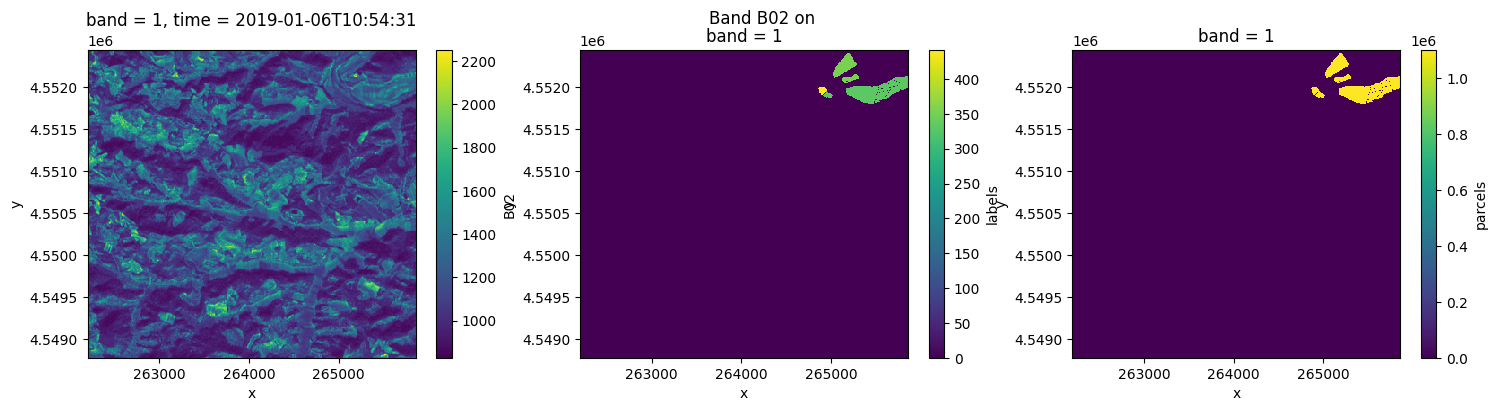

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

fig.suptitle(f'Band B02 on')

band_data = bands['B02']['band']
band_data.isel(time=0).plot(ax=ax[0])
#ax[0].set_title('Band Data')

labels = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels']))
print('label indexes:', np.unique(labels.to_dataarray()))
labels.labels.plot(ax=ax[1])
#ax[0].set_title('Labels')

parcels = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['parcels']))
print('parcel ids:', np.unique(parcels.to_dataarray()))
parcels.parcels.plot(ax=ax[2])

In [5]:
print(band_data.isel(time=0).time.dt.strftime("%Y").coords['time'])

<xarray.DataArray 'time' ()> Size: 8B
array('2019-01-06T10:54:31.000000000', dtype='datetime64[ns]')
Coordinates:
    band     int64 8B ...
    time     datetime64[ns] 8B 2019-01-06T10:54:31


In [6]:
timeslice = band_data.isel(time=0)

In [7]:
ftime = timeslice.time.dt.strftime("%Y-%m-%d %H:%M:%S")
print(ftime.values)
print(timeslice.time.values)

2019-01-06 10:54:31
2019-01-06T10:54:31.000000000


## Decode label names

In [8]:
labels

<xarray.Dataset> Size: 542kB
Dimensions:  (y: 366, x: 366)
Coordinates:
    band     int64 8B ...
  * y        (y) float64 3kB 4.552e+06 4.552e+06 ... 4.549e+06 4.549e+06
  * x        (x) float64 3kB 2.622e+05 2.622e+05 ... 2.658e+05 2.659e+05
Data variables:
    labels   (y, x) uint32 536kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

## Mask a band of a by individual crop labels

In [20]:
label_array = np.array(labels.to_dataarray()[0])
unique_indexes = np.unique(label_array)
print(unique_indexes)

[  0 330 353 442]


In [21]:
CROP_DECODING = dict((v,k) for k, v in CROP_ENCODING.items())
CROP_DECODING[0] = "UNDEFINED"
fields = np.vectorize(CROP_DECODING.get)(unique_indexes)
print(fields)

['UNDEFINED' 'Grapes' 'Cherries and sour cherries' 'Olives']


In [22]:
band_array = np.array(band_data.isel(time=0))
type(band_array), band_array.shape

(numpy.ndarray, (366, 366))

In [23]:
band_array = np.array(band_data.isel(time=0))
type(band_array), band_array.shape, band_array.dtype

(numpy.ndarray, (366, 366), dtype('uint16'))

In [24]:
olives = band_array.copy()
olives[label_array!=CROP_ENCODING['Olives']] = 0
grapes = band_array.copy()
grapes[label_array!=CROP_ENCODING['Grapes']] = 0
cherries = band_array.copy()
cherries[label_array!=CROP_ENCODING['Cherries and sour cherries']] = 0

In [29]:
patch.patch_name

'patch_17_13'

Text(0.5, 1.0, 'Cherries and sour cherries')

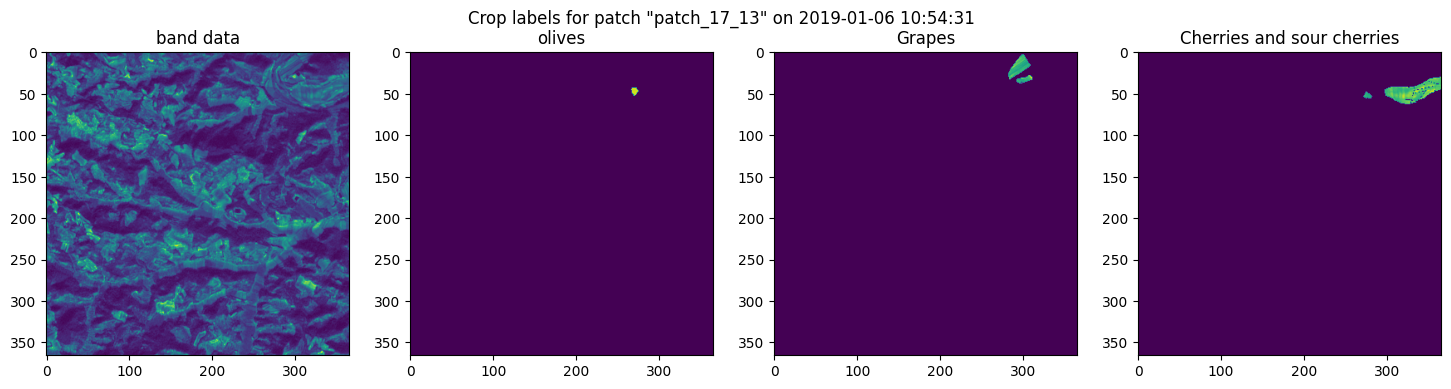

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
fig.suptitle(f'Crop labels for patch "{patch.patch_name}" on {timeslice.time.dt.strftime("%Y-%m-%d %H:%M:%S").values}')
ax[0].imshow(band_array)
ax[0].set_title('band data')
ax[1].imshow(olives)
ax[1].set_title('olives')
ax[2].imshow(cherries)
ax[2].set_title('Grapes')
ax[3].imshow(grapes)
ax[3].set_title('Cherries and sour cherries')

In [93]:
olives_highlight = olives.copy()
indicies = np.where((olives_highlight > 0))
print(np.array(indicies).shape)
print(indicies)

(2, 59)
(array([44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46,
       46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48,
       48, 48, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 51, 51,
       51, 51, 51, 52, 52, 52, 53, 53]), array([267, 268, 269, 270, 271, 272, 267, 268, 269, 270, 271, 272, 266,
       267, 268, 269, 270, 271, 272, 273, 267, 268, 269, 270, 271, 272,
       273, 274, 267, 268, 269, 270, 271, 272, 273, 274, 267, 268, 269,
       270, 271, 272, 273, 267, 268, 269, 270, 271, 272, 268, 269, 270,
       271, 272, 269, 270, 271, 269, 270]))


<class 'tuple'> 2 59
(2, 59)
<class 'tuple'> 2 59


Text(0.5, 1.0, 'olives highlight')

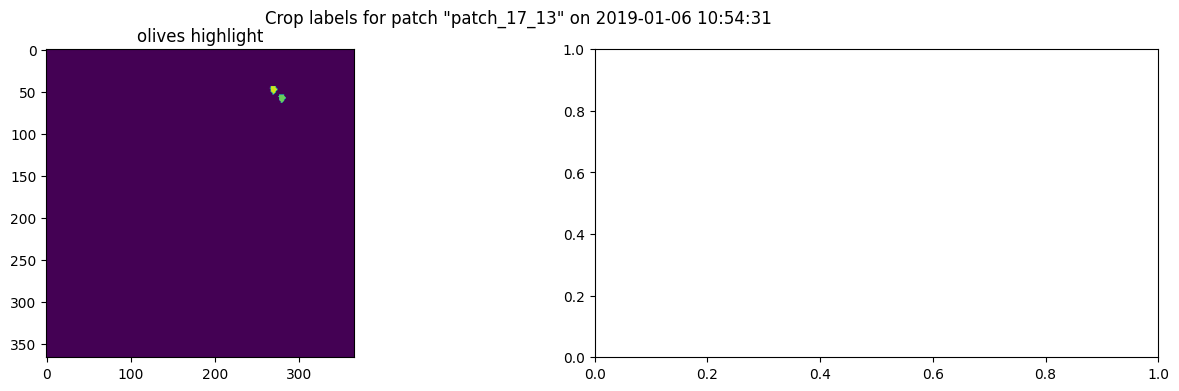

In [106]:
olives_highlight = olives.copy()
indicies = np.where((olives_highlight > 0))
print(type(indicies), len(indicies), len(indicies[1]))
ai = np.array(indicies) + 10
print(ai.shape)
shift1 = tuple(ai)
print(type(shift1), len(shift1), len(shift1[1]))
olives_highlight[shift1] = 1000
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'Crop labels for patch "{patch.patch_name}" on {timeslice.time.dt.strftime("%Y-%m-%d %H:%M:%S").values}')
ax[0].imshow(olives_highlight)
ax[0].set_title('olives highlight')

Text(0.5, 1.0, 'olives highlight')

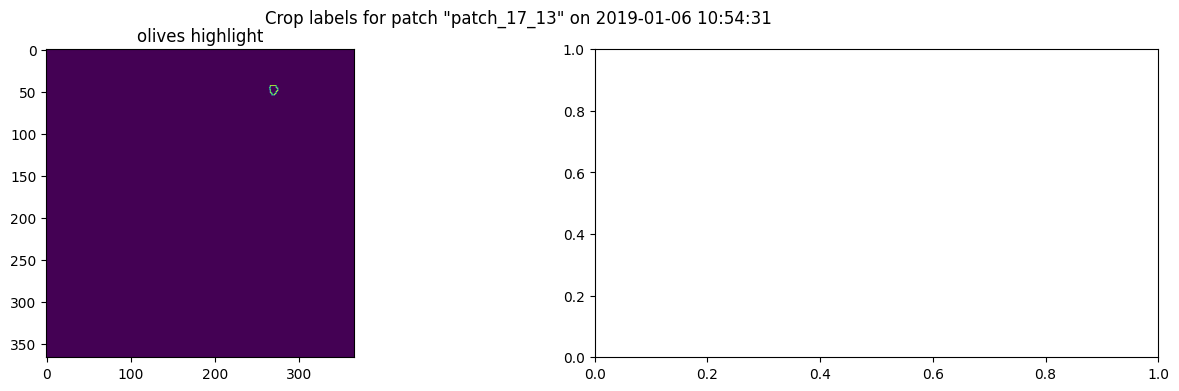

In [179]:
color = 20000
olives_highlight = olives.copy()
indicies = np.where((olives_highlight > 0))

# Outline image
ai = np.array(indicies) + 1
olives_highlight[tuple(ai)] = color
ai[0] = np.array(indicies)[0] - 1
olives_highlight[tuple(ai)] = color
ai[0] = np.array(indicies)[0] - 1
olives_highlight[tuple(ai)] = color
ai[1] = np.array(indicies)[1] - 1
olives_highlight[tuple(ai)] = color
ai[1] = np.array(indicies)[1] - 1
olives_highlight[tuple(ai)] = color
ai[0] = np.array(indicies)[0] + 1
olives_highlight[tuple(ai)] = color
ai[0] = np.array(indicies)[0] + 1
olives_highlight[tuple(ai)] = color
ai[1] = np.array(indicies)[1] + 1
olives_highlight[tuple(ai)] = color

# Remove center
olives_highlight[olives > 0] = 0

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'Crop labels for patch "{patch.patch_name}" on {timeslice.time.dt.strftime("%Y-%m-%d %H:%M:%S").values}')
ax[0].imshow(olives_highlight)
ax[0].set_title('olives highlight')

Text(0.5, 1.0, 'olives highlight')

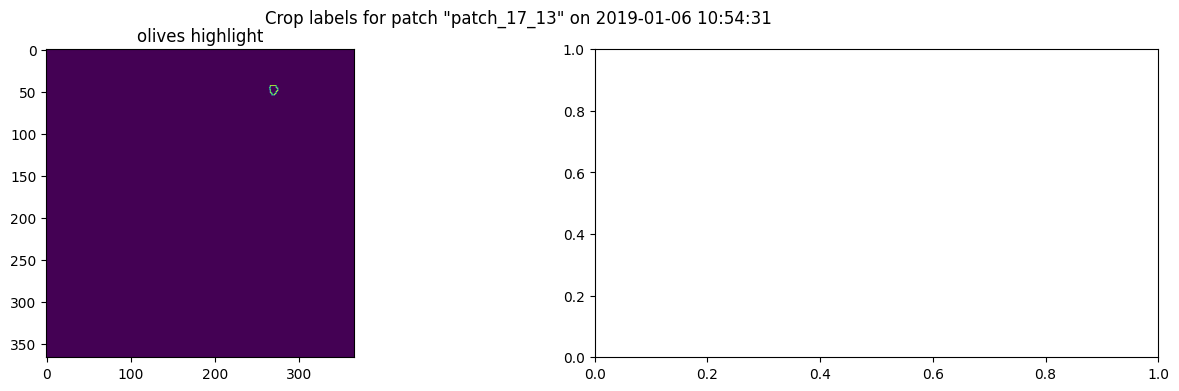

In [184]:
color = 1
olives_highlight = olives.copy()
indicies = np.where((olives_highlight > 0))

# Expand the image by 1 pixel on all sides
# TODO: determine how to do this without a loop
# TODO: consider generic_filter
ai = np.array(indicies) + 1
for addsub in [-1, 1]:
    for idx in range(2):
        for n in range(2):
            olives_highlight[tuple(ai)] = color
            ai[idx] = np.array(indicies)[idx] + addsub

# Remove center
olives_highlight[olives > 0] = 0

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'Crop labels for patch "{patch.patch_name}" on {timeslice.time.dt.strftime("%Y-%m-%d %H:%M:%S").values}')
ax[0].imshow(olives_highlight)
ax[0].set_title('olives highlight')

In [186]:
def draw_outline_image(image, color=1):
    color = 1
    outline_image = image.copy()
    indicies = np.where((outline_image > 0))
    
    # Expand the image by 1 pixel on all sides
    # TODO: determine how to do this without a loop
    # TODO: consider generic_filter
    ai = np.array(indicies) + 1
    for addsub in [-1, 1]:
        for idx in range(2):
            for n in range(2):
                outline_image[tuple(ai)] = color
                ai[idx] = np.array(indicies)[idx] + addsub
    
    # Remove center
    outline_image[olives > 0] = 0
    return outline_image

Text(0.5, 1.0, 'olives highlight')

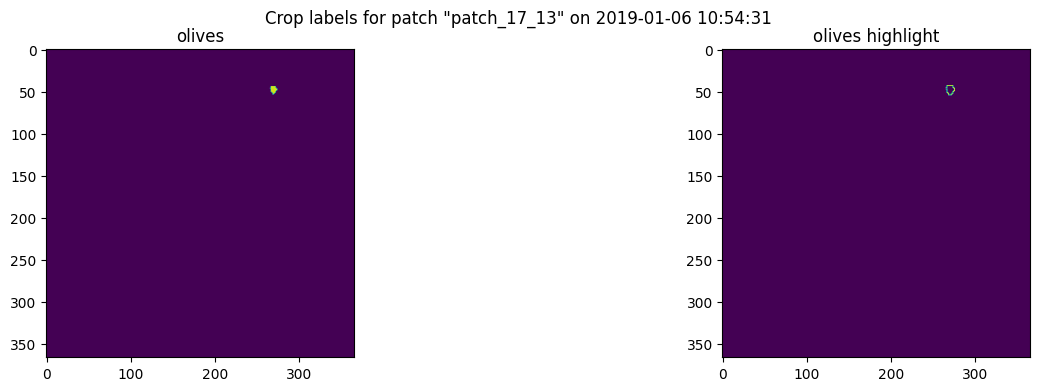

In [188]:
outline = draw_outline_image(olives, 1000)
# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'Crop labels for patch "{patch.patch_name}" on {timeslice.time.dt.strftime("%Y-%m-%d %H:%M:%S").values}')
ax[0].imshow(olives)
ax[0].set_title('olives')
ax[1].imshow(outline)
ax[1].set_title('olives highlight')

In [150]:
i[:,0] = np.array(indicies)

array([[ 44,  44,  44,  44,  44,  44,  45,  45,  45,  45,  45,  45,  46,
         46,  46,  46,  46,  46,  46,  46,  47,  47,  47,  47,  47,  47,
         47,  47,  48,  48,  48,  48,  48,  48,  48,  48,  49,  49,  49,
         49,  49,  49,  49,  50,  50,  50,  50,  50,  50,  51,  51,  51,
         51,  51,  52,  52,  52,  53,  53],
       [267, 268, 269, 270, 271, 272, 267, 268, 269, 270, 271, 272, 266,
        267, 268, 269, 270, 271, 272, 273, 267, 268, 269, 270, 271, 272,
        273, 274, 267, 268, 269, 270, 271, 272, 273, 274, 267, 268, 269,
        270, 271, 272, 273, 267, 268, 269, 270, 271, 272, 268, 269, 270,
        271, 272, 269, 270, 271, 269, 270]])

In [151]:
np.array(indicies)[0] + 1

array([45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47,
       47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49,
       49, 49, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 52, 52,
       52, 52, 52, 53, 53, 53, 54, 54])

In [90]:
#shift1.reshape([59,2])

In [91]:
#np.max(olives_highlight)
#olives_highlight[shift1] = 700

Text(0.5, 1.0, 'olives highlight')

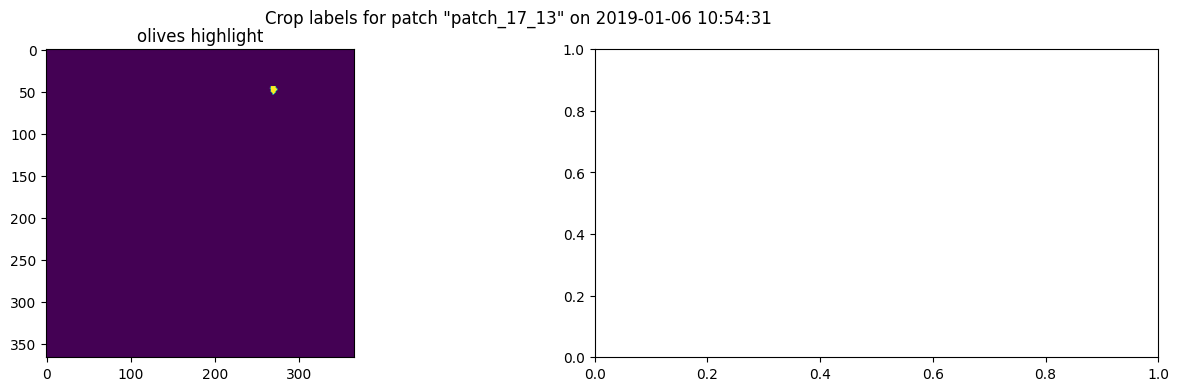

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'Crop labels for patch "{patch.patch_name}" on {timeslice.time.dt.strftime("%Y-%m-%d %H:%M:%S").values}')
ax[0].imshow(olives_highlight)
ax[0].set_title('olives highlight')

## TODO

* Highlight label bounding boxes
* Highlight parcels -- draw border

## View Parcel Properties

In [ ]:
parcels.parcels[0,0]

In [ ]:
# Or maybe aggregate based on a given frequency
# Refer to
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
group_freq = '1MS'

# Grab year from netcdf4's global attribute
year = patch.patch_year

# output intervals
date_range = pd.date_range(start=f'{year}-01-01', end=f'{int(year) + 1}-01-01', freq=group_freq)

# Aggregate based on given frequency
band_data = band_data.groupby_bins(
    'time',
    bins=date_range,
    right=True,
    include_lowest=False,
    labels=date_range[:-1]
).median(dim='time')

In [ ]:
import matplotlib.pyplot as plt

band_data = band_data.interpolate_na(dim='time_bins', method='linear', fill_value='extrapolate')

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))

for i, season in enumerate(band_data.B02):

    ax = axes.flat[i]
    cax = band_data.B02.isel(time_bins=i).plot(ax=ax)


for i, ax in enumerate(axes.flat):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Month: {i+1}')


plt.tight_layout()
plt.show()

In [ ]:
band_data_B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02']))
band_data_B02.B02.isel(time=0).plot()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
red = np.array(bands['B04']['band'].isel(time=0)).flatten()
ax0 = axes[0].hist([red, (bands['B02']['uint8']).flatten(), bands['B03']['uint8'].flatten()], bins=256)
ax1 = axes[1].hist([bands['B04']['uint8'].flatten(), bands['B02']['uint8'].flatten(), bands['B03']['uint8'].flatten()], bins=256)

In [ ]:
xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03.isel(time=0).plot()

## A Visualization of the various 10m Channel Views: Red, Green, Blue, and NIR

#### Combine Blue, Green, and Red channels into an RGB image

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02.isel(time=0)
B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03.isel(time=0)
B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04.isel(time=0)
B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08.isel(time=0)

blue8 = np.array((B02 / 16).astype(np.uint8))
green8 = np.array((B03 / 16).astype(np.uint8))
red8 = np.array((B04 / 16).astype(np.uint8))
nir8 = np.array((B08 / 16).astype(np.uint8))

bands = [
    {'title': 'B02 - Blue',  'band': B02, 'uint8': blue8,  'plotc': 'b'},
    {'title': 'B03 - Green', 'band': B03, 'uint8': green8, 'plotc': 'g'},
    {'title': 'B04 - Red',   'band': B04, 'uint8': red8,   'plotc': 'r'},
    {'title': 'B08 - NIR',   'band': B08, 'uint8': nir8,   'plotc': 'y'}
]

print(f'{[b["title"] for b in bands]}')
bmean = np.mean([np.array(b["band"]) for b in bands], axis=0)
print(f'{bmean.shape}, {bmean.dtype}')

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(nrows=len(bands), ncols=4, width_ratios=[2, 2, 2, 7])

xmin = 0
xmax = np.max(np.concatenate((np.array(B02).flatten(), np.array(B03).flatten(), np.array(B04).flatten())))
print(f'xlim: {xmin} - {xmax}')

ymin = 0
ymax = 5500

for n,band in enumerate(bands):
    ax = fig.add_subplot(gs[n, 0])
    ax.hist(np.array(band['band']).flatten(), bins=128, facecolor=band['plotc'])
    #ax.hist(blue8.astype("float32").flatten(), bins=100, facecolor='b')
    ax.set_title(band['title'])
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_ylim((ymin,ymax))
    ax.set_xlim((xmin,xmax))

    axim = fig.add_subplot(gs[n, 1])
    axim.imshow(band['band'], cmap='gray')
    axim.set_xticks([])
    axim.set_yticks([])

    axim = fig.add_subplot(gs[n, 2])
    axim.imshow(band['band'] - bmean, cmap='gray')
    axim.set_xticks([])
    axim.set_yticks([])

axim = fig.add_subplot(gs[:, -1])
rgb3 = np.dstack((red8, green8, blue8))
axim.imshow(rgb3)
axim.set_xticks([])
axim.set_yticks([])

fig.tight_layout()
fig.subplots_adjust(wspace=-0.1)

plt.show()

In [ ]:
def visualize_patch(patch, time=0):
    B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02.isel(time=time)
    B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03.isel(time=time)
    B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04.isel(time=time)
    B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08.isel(time=time)
    
    blue8 = np.array((B02 / 16).astype(np.uint8))
    green8 = np.array((B03 / 16).astype(np.uint8))
    red8 = np.array((B04 / 16).astype(np.uint8))
    nir8 = np.array((B08 / 16).astype(np.uint8))
    
    # TODO: make a nested dict
    #bandsdict = {
    #    {'blue':  {'title': 'B02 - Blue',  'band': np.array(B02), 'uint8': blue8,  'plotc': 'b'}},
    #    {'green': {'title': 'B03 - Green', 'band': np.array(B03), 'uint8': green8, 'plotc': 'g'}},
    #    {'red':   {'title': 'B04 - Red',   'band': np.array(B04), 'uint8': red8,   'plotc': 'r'}},
    #    {'nir':   {'title': 'B08 - NIR',   'band': np.array(B08), 'uint8': nir8,   'plotc': 'y'}}
    #}
    
    bands = [
        {'title': 'B02 - Blue',  'band': B02, 'uint8': blue8,  'plotc': 'b'},
        {'title': 'B03 - Green', 'band': B03, 'uint8': green8, 'plotc': 'g'},
        {'title': 'B04 - Red',   'band': B04, 'uint8': red8,   'plotc': 'r'},
        {'title': 'B08 - NIR',   'band': B08, 'uint8': nir8,   'plotc': 'y'}
    ]
    
    bmean = np.mean([np.array(b["band"]) for b in bands], axis=0)
    
    fig = plt.figure(figsize=(18, 7))
    gs = fig.add_gridspec(nrows=len(bands), ncols=5, width_ratios=[2, 2, 2, 6, 2])
    
    xmin = 0
    xmax = np.max(np.concatenate((np.array(B02).flatten(), np.array(B03).flatten(), np.array(B04).flatten())))
    
    ymin = 0
    ymax = 5500
    
    for n,band in enumerate(bands):

        axim1 = fig.add_subplot(gs[n, 0])
        axim1.imshow(band['band'], cmap='gray')
        axim1.set_title('amplitude ')
        axim1.set_ylabel(band['title'], fontsize=16)
    
        ax = fig.add_subplot(gs[n, 1])
        ax.hist(np.array(band['band']).flatten(), bins=128, facecolor=band['plotc'])

        ax.set_title('histogram')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim((ymin,ymax))
        ax.set_xlim((xmin,xmax))
    
        axim2 = fig.add_subplot(gs[n, 2])
        axim2.imshow(band['band'] - bmean, cmap='gray')
        axim2.set_title('mean delta')
        axim2.set_xticks([])
        axim2.set_yticks([])
    
    NDVI = (B08 - B04) / (B08 + B04)
    ax_ndvi = fig.add_subplot(gs[0, -1])
    ax_ndvi.imshow(np.array(NDVI))
    ax_ndvi.set_title('NDVI')
    ax_ndvi.set_xticks([])
    ax_ndvi.set_yticks([])
    
    ax_ndvi_h = fig.add_subplot(gs[1, -1])
    ax_ndvi_h.hist(np.array(NDVI).flatten(), bins=128, facecolor=band['plotc'])
    ax_ndvi_h.set_title('NDVI Histogram')
    ax_ndvi_h.set_ylim((0, 3))
    ax_ndvi_h.set_xticks([])
    ax_ndvi_h.set_yticks([])
    
    NDWI = (B03 - B08) / (B03 + B08)
    ax_ndwi = fig.add_subplot(gs[2, -1])
    ax_ndwi.imshow(NDWI)
    ax_ndwi.set_title('NDWI')
    ax_ndwi.set_xticks([])
    ax_ndwi.set_yticks([])
    
    ax_ndwi_h = fig.add_subplot(gs[3, -1])
    ax_ndwi_h.hist(np.array(NDWI).flatten(), bins=128, facecolor=band['plotc'])
    ax_ndwi.set_title('NDWI')
    ax_ndwi_h.set_title('NDWI Histogram')
    ax_ndwi_h.set_ylim((0, 3500))
    ax_ndwi_h.set_xticks([])
    ax_ndwi_h.set_yticks([])
    
    axim = fig.add_subplot(gs[:, 3])
    rgb3 = np.dstack((red8, green8, blue8))
    axim.imshow(rgb3)
    #print(f'{band["band"].time}')
    band_time = band['band'].time.dt.isocalendar()
    #print(f'band_time type: {type(band_time)}')
    #print(f'band_time items: {str(band_time.to_dict())}')
    band_dict = band_time.to_dict()
    #print(f'band_dict_coords: {band_dict["coords"]}')
    #print(f'band_dict_coords_data: {band_dict["coords"].keys()}')
    #print(f'band_dict_coords_time: {band_dict["coords"]["time"]}')
    #print(f'band_dict_coords_time_data: {band_dict["coords"]["time"]["data"]}')
    axim.set_title('Combined Channels R,G, and B at ' + str(band_dict["coords"]["time"]["data"]))
    axim.set_xlabel(f'Pixel Dimensions: {rgb.shape} px / 10m per pixel / {rgb.shape[0]*10}x{rgb.shape[1]*10} meters')
    #axim.set_xlabel(f'Pixel Dimensions: {rgb.shape} px / 10m per pixel / {band_dict["coords"]["time"]["data"]} meters')
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0)
    
    plt.show()

visualize_patch(patch, time=0)

In [ ]:
visualize_patch(patch, time=4)

In [ ]:
visualize_patch(patch, time=10)

In [ ]:
visualize_patch(patch, time=12)

## TODO

1. Set histogram width to 1:1 ratio
2. 2D histograms with time
3. Plot residuals
4. Plot a small section of a patch
5. Plot a crop type using a mask 

In [ ]:
def plot_im(ax, key, im):
    ax.imshow(np.array(im))
    ax.set_title(key)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
def plot_hist(ax, key, arr, ylim, color=band['plotc']):
    ax.hist(np.array(arr).flatten(), bins=128, facecolor=color)
    ax.set_title(f'{key} Histogram')
    ax.set_ylim((0, ylim))
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
def plot_bar3d(ax, band, color='blue'):
    print(type(band), band.shape)
    nbins = 16
    fig = plt.figure()
    for n in range(band.shape[0]):
        hist, _ = np.histogram(band[n,:,:], bins=nbins)
        width = depth = 1
        z = np.zeros(hist.shape[0])
        ax.bar3d(np.arange(nbins), n, z, width, depth, hist, color=color, shade=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    #ax.view_init(elev=15, azim=-65, roll=0)

In [ ]:
def plot_bar3d_2(ax, band):
    print(type(band), band.shape)
    max = np.max(band)
    #cmap = plt.cm.get_cmap('jet')
    cmap = plt.colormaps['jet']
    nbins = 16
    fig = plt.figure()
    for n in range(band.shape[0]):
        hist, _ = np.histogram(band[n,:,:], bins=nbins)
        width = depth = 1
        z = np.zeros(hist.shape[0])
        rgba = [cmap((k-np.min(band))/np.max(band)*.10) for k in hist]
        ax.bar3d(np.arange(nbins), n, z, width, depth, hist, color=rgba, shade=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

In [ ]:
#type(xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])))

In [ ]:
#xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).get([0])

In [ ]:
def visualize_patch_hist_1_1(patch, time=0):
    B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02.isel(time=time)
    B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03.isel(time=time)
    B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04.isel(time=time)
    B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08.isel(time=time)
    
    blue8 = np.array((bandsdict['B02']['band'] / 16).astype(np.uint8))
    green8 = np.array((bandsdict['B03']['band'] / 16).astype(np.uint8))
    red8 = np.array((bandsdict['B04']['band'] / 16).astype(np.uint8))
    nir8 = np.array((bandsdict['B08']['band'] / 16).astype(np.uint8))
    
    bmean = np.mean([np.array(b["band"]) for b in bands], axis=0)
    
    fig = plt.figure(figsize=(18, 7))
    gs = fig.add_gridspec(nrows=len(bands), ncols=6, width_ratios=[2, 1, 2, 1, 6, 1])
    
    xmin = 0
    xmax = np.max(np.concatenate((np.array(B02).flatten(), np.array(B03).flatten(), np.array(B04).flatten())))
    
    ymin = 0
    ymax = 5500
    
    for n,band in enumerate(bands):

        axim1 = fig.add_subplot(gs[n, 0])
        axim1.imshow(band['band'], cmap='gray')
        axim1.set_title('amplitude ')
        axim1.set_ylabel(band['title'], fontsize=16)
    
        ax = fig.add_subplot(gs[n, 1])
        ax.hist(np.array(band['band']).flatten(), bins=128, facecolor=band['plotc'])

        ax.set_title('histogram')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim((ymin,ymax))
        ax.set_xlim((xmin,xmax))
    
        axim2 = fig.add_subplot(gs[n, 2])
        axim2.imshow(band['band'] - bmean, cmap='gray')
        axim2.set_title('mean delta')
        axim2.set_xticks([])
        axim2.set_yticks([])

    npb02 = np.array(xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02)
    ax3d = fig.add_subplot(gs[0, 3], projection='3d')
    plot_bar3d_2(ax3d, npb02)

    npb03 = np.array(xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03)
    ax3d = fig.add_subplot(gs[1, 3], projection='3d')
    plot_bar3d_2(ax3d, npb03)

    axim = fig.add_subplot(gs[:, 4])
    rgb3 = np.dstack((red8, green8, blue8))
    axim.imshow(rgb3)
    band_time = band['band'].time.dt.isocalendar()
    band_dict = band_time.to_dict()
    axim.set_title('Combined Channels R,G, and B at ' + str(band_dict["coords"]["time"]["data"]))
    axim.set_xlabel(f'Pixel Dimensions: {rgb.shape} px / 10m per pixel / {rgb.shape[0]*10}x{rgb.shape[1]*10} meters')
    
    NDVI = (B08 - B04) / (B08 + B04)
    NDWI = (B03 - B08) / (B03 + B08)

    ax_ndvi = fig.add_subplot(gs[0, -1])
    _ = plot_im(ax_ndvi, 'NDVI', NDVI)
    ax_ndvi_h = fig.add_subplot(gs[1, -1])
    ax_ndvi_h.hist(np.array(NDVI).flatten(), bins=128, facecolor=band['plotc'])
    plot_hist(ax_ndvi_h, 'NDVI', NDVI, 8)

    ax_ndwi = fig.add_subplot(gs[2, -1])
    _ = plot_im(ax_ndwi, 'NDWI', NDWI)
    ax_ndwi_h = fig.add_subplot(gs[3, -1])
    ax_ndwi_h.hist(np.array(NDWI).flatten(), bins=128, facecolor=band['plotc'])
    plot_hist(ax_ndwi_h, 'NDWI', NDWI, 3500)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0)
    
    plt.show()

visualize_patch_hist_1_1(patch, time=0)

In [ ]:
# From https://stackoverflow.com/questions/44895117/colormap-for-3d-bar-plot-in-matplotlib-applied-to-every-bar
# Author: Ryan Dorrill
# Online: 2024-04-05

xAmplitudes = np.random.exponential(10,10000) #your data here
yAmplitudes = np.random.normal(50,10,10000) #your other data here - must be same array length

x = np.array(xAmplitudes)   #turn x,y data into numpy arrays
y = np.array(yAmplitudes)   #useful for regular matplotlib arrays

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram stuff - set bins - I choose 20x20 because I have a lot of data
hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = plt.cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
plt.title("X vs. Y Amplitudes for ____ Data")
plt.xlabel("My X data source")
plt.ylabel("My Y data source")
plt.savefig("Your_title_goes_here")
plt.show()

In [ ]:
colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]
for c, k in zip(colors, yticks):
    print(f'c={c}, k={k}')

In [ ]:
nbins = 32
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for n in range(npb02.shape[0]):
    hist, _ = np.histogram(npb02[n,:,:], bins=nbins)
    ax.bar(np.arange(nbins), hist, n, zdir='y', alpha=0.8)
plt.show()

In [ ]:
nbins = 256
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
max = np.max(npb02)
cmap = plt.cm.get_cmap('jet')

for n in range(npb02.shape[0]):
    hist, _ = np.histogram(npb02[n,:,:], bins=nbins)
    width = depth = 1
    z = np.zeros(hist.shape[0])
    rgba = [cmap((k+600)/max_height*.25) for k in hist] 
    ax.bar3d(np.arange(nbins), n, z, width, depth, hist, color=rgba, shade=True)
ax.view_init(elev=15, azim=-75, roll=0)
plt.show()